# dxdy

In [1]:
import json
import os, re
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from pymystem3 import Mystem # контекстный лемматизатор


def stop_words():
    """стоп-слова"""
    lst = set()
    with open('stop-ru.txt', 'r', encoding='utf-8') as f:
        for line in f:
            word = re.sub(r'\n', '', line)
            lst.add(word)
    return lst


def folder_names(my_path):
    """список названий папок в датасете"""
    list_files_and_folders = os.listdir(path=my_path)
    folders = set()
    for elem in list_files_and_folders:
        s = re.search(r'[\w,\W]+[^(.data)]', elem)
        if s:
            folders.add(s.group())
    return folders


def forum_names():
    """словарь: ключи - коды форумов, значения - их названия"""
    d = {}
    with open('dxdy.ru Форум - название.txt', 'r', encoding='utf-8') as f:
        for line in f:
            number = re.search(r'\d+', line).group()
            pattern = number + ':'
            pattern2 = '\ufeff'
            name = re.sub(fr'{pattern}|\n|{pattern2}', '', line)
            d[number] = name
    return d


def read_file(X, y, numb, path_files, file):
    """чтение файла"""
    with open(path_files + '\\' + file, encoding = 'utf-8') as f:
        data = json.load(f)
        for dic_data in data['posts']:
            for dic in dic_data['content']:
                for key in dic:
                    st = dic[key].replace('\n', '')
                    st = re.sub(r'\s\s+', ' ', st)
                    X.append(st)
                    y.append(numb)


def read_dataset(path):
    """чтение данных"""
    X, y = [], []

    for elem in folder_names(path):
        numb = re.search(r'\d+', elem).group()
        path_files = path + '\\' + elem
        for file in os.listdir(path=path_files):
            read_file(X, y, numb, path_files, file)
    return X, y

In [7]:
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score

import dataframe_image as dfi

In [3]:
dataset_folder = 'dataset'
stop_w = stop_words()
names = forum_names()
X, y = read_dataset(dataset_folder)

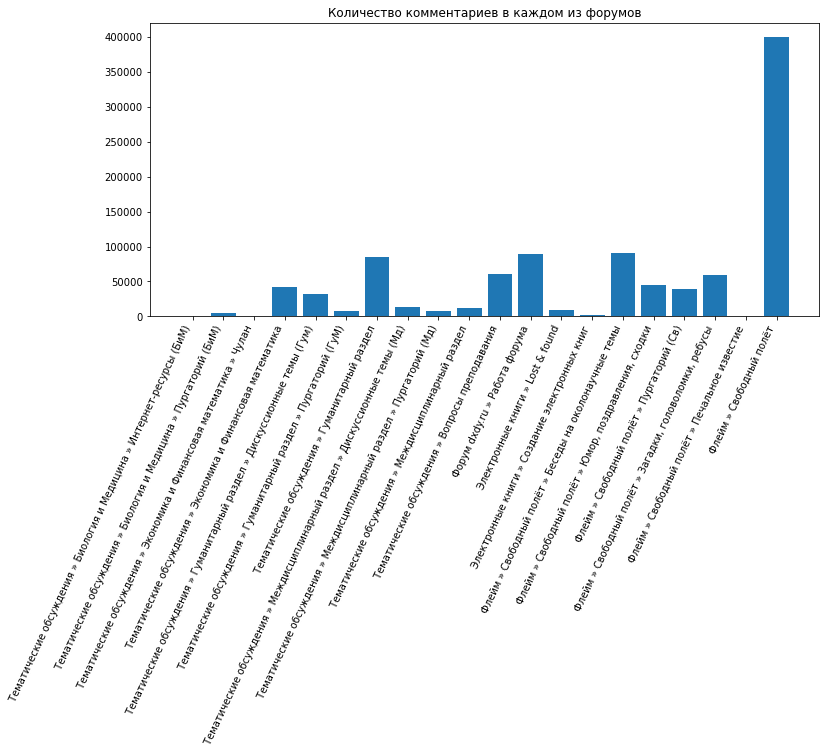

In [4]:
# сбалансированности нет, к сожалению
fig, ax = plt.subplots()
plt.title('Количество комментариев в каждом из форумов')

ax.bar(names.values(), [y.count(code) for code in names])

fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure
fig.autofmt_xdate(rotation = 65)

plt.show()

In [5]:
#nltk.download('wordnet')
#nltk.download('punkt')       

lemmatizer = WordNetLemmatizer()

def lemmatize_sentence(text):
    lemmas = Mystem().lemmatize(text)
    rus_eng_correct_text = ''.join([lemmatizer.lemmatize(w) for w in lemmas]).strip()
    return rus_eng_correct_text
names

{'00013463': ' Тематические обсуждения » Биология и Медицина » Интернет-ресурсы (БиМ)',
 '00013368': ' Тематические обсуждения » Биология и Медицина » Пургаторий (БиМ)',
 '00012007': ' Тематические обсуждения » Экономика и Финансовая математика » Чулан',
 '00011989': ' Тематические обсуждения » Экономика и Финансовая математика',
 '00010785': ' Тематические обсуждения » Гуманитарный раздел » Дискуссионные темы (Гум)',
 '00010729': ' Тематические обсуждения » Гуманитарный раздел » Пургаторий (ГуМ)',
 '00010713': ' Тематические обсуждения » Гуманитарный раздел',
 '00010424': ' Тематические обсуждения » Междисциплинарный раздел » Дискуссионные темы (Мд)',
 '00010286': ' Тематические обсуждения » Междисциплинарный раздел » Пургаторий (Мд)',
 '00010260': ' Тематические обсуждения » Междисциплинарный раздел',
 '00009641': ' Тематические обсуждения » Вопросы преподавания',
 '00007929': ' Форум dxdy.ru » Работа форума',
 '00006456': ' Электронные книги » Lost & found',
 '00006380': ' Электронн

In [6]:
baseline = y.count('00000003') / len(y)
baseline

0.39923932743051954

CountVectorizer() - построение для каждого комментария вектора количеств каждого слова из словаря всех слов;
TfidfVectorizer() - использование меры TF-IDF: TF-IDF(термина а) = TF(термина а) * IDF(термина а), IDF(термина а) = Log(Общее количество документов / Количество документов, в которых встречается термин а) - важность термина a, TF(термина а) = (Количество раз, когда термин а встретился в тексте / количество всех слов в тексте)

In [13]:
vectorizers = ['CountVectorizer', 'TfidfVectorizer']
methods = ['MultinomialNB', 'BernoulliNB']
# alpha - параметр сглаживания, 1.0 по умолчанию
# norm - False по умолчанию
vectorizer_params = [('binary=True'),('binary=True, stop_words=list(stop_w)')]

In [18]:
A = [[[[-1 for al in range(31)] for method in range(2)] for param in range(2)] for vect in range(2)]
i = 1
my_methods = {0: 'MultinomialNB', 1: 'BernoulliNB'}
my_params = {0: ('binary=True'), 1: ('binary=True, stop_words=list(stop_w)')}
my_vect = {0: 'CountVectorizer', 1: 'TfidfVectorizer'}
for vect in range(2):
    for param in range(2):
        vectorizer = eval(f'{my_vect[vect]}({my_params[param]})')
        
        X_vect = vectorizer.fit_transform(X)
        
        X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)
        for method in range(2):
            for al in range(31):
                clf = eval(f'{my_methods[method]}(alpha=0.1 * {al})')
                clf.fit(X_train, y_train)
                y_pred_train = clf.predict(X_train)
                y_pred_test = clf.predict(X_test)
                train = accuracy_score(y_train, y_pred_train)
                test = accuracy_score(y_test, y_pred_test)
                if train - test < 0.12:
                    A[vect][param][method][al] = (train, test)
                print(f'Выполнено {i * 100 / 248}%')
                i += 1

C:\Anaconda\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


Выполнено 0.4032258064516129%
Выполнено 0.8064516129032258%
Выполнено 1.2096774193548387%
Выполнено 1.6129032258064515%
Выполнено 2.0161290322580645%
Выполнено 2.4193548387096775%
Выполнено 2.8225806451612905%
Выполнено 3.225806451612903%
Выполнено 3.629032258064516%
Выполнено 4.032258064516129%
Выполнено 4.435483870967742%
Выполнено 4.838709677419355%
Выполнено 5.241935483870968%
Выполнено 5.645161290322581%
Выполнено 6.048387096774194%
Выполнено 6.451612903225806%
Выполнено 6.854838709677419%
Выполнено 7.258064516129032%
Выполнено 7.661290322580645%
Выполнено 8.064516129032258%
Выполнено 8.46774193548387%
Выполнено 8.870967741935484%
Выполнено 9.274193548387096%
Выполнено 9.67741935483871%
Выполнено 10.080645161290322%
Выполнено 10.483870967741936%
Выполнено 10.887096774193548%
Выполнено 11.290322580645162%
Выполнено 11.693548387096774%
Выполнено 12.096774193548388%
Выполнено 12.5%


C:\Anaconda\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


Выполнено 12.903225806451612%
Выполнено 13.306451612903226%
Выполнено 13.709677419354838%
Выполнено 14.112903225806452%
Выполнено 14.516129032258064%
Выполнено 14.919354838709678%
Выполнено 15.32258064516129%
Выполнено 15.725806451612904%
Выполнено 16.129032258064516%
Выполнено 16.532258064516128%
Выполнено 16.93548387096774%
Выполнено 17.338709677419356%
Выполнено 17.741935483870968%
Выполнено 18.14516129032258%
Выполнено 18.548387096774192%
Выполнено 18.951612903225808%
Выполнено 19.35483870967742%
Выполнено 19.758064516129032%
Выполнено 20.161290322580644%
Выполнено 20.56451612903226%
Выполнено 20.967741935483872%
Выполнено 21.370967741935484%
Выполнено 21.774193548387096%
Выполнено 22.177419354838708%
Выполнено 22.580645161290324%
Выполнено 22.983870967741936%
Выполнено 23.387096774193548%
Выполнено 23.79032258064516%
Выполнено 24.193548387096776%
Выполнено 24.596774193548388%
Выполнено 25.0%


C:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['первых', 'прежнему'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
C:\Anaconda\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


Выполнено 25.403225806451612%
Выполнено 25.806451612903224%
Выполнено 26.20967741935484%
Выполнено 26.612903225806452%
Выполнено 27.016129032258064%
Выполнено 27.419354838709676%
Выполнено 27.822580645161292%
Выполнено 28.225806451612904%
Выполнено 28.629032258064516%
Выполнено 29.032258064516128%
Выполнено 29.43548387096774%
Выполнено 29.838709677419356%
Выполнено 30.241935483870968%
Выполнено 30.64516129032258%
Выполнено 31.048387096774192%
Выполнено 31.451612903225808%
Выполнено 31.85483870967742%
Выполнено 32.25806451612903%
Выполнено 32.66129032258065%
Выполнено 33.064516129032256%
Выполнено 33.46774193548387%
Выполнено 33.87096774193548%
Выполнено 34.274193548387096%
Выполнено 34.67741935483871%
Выполнено 35.08064516129032%
Выполнено 35.483870967741936%
Выполнено 35.88709677419355%
Выполнено 36.29032258064516%
Выполнено 36.693548387096776%
Выполнено 37.096774193548384%
Выполнено 37.5%


C:\Anaconda\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


Выполнено 37.903225806451616%
Выполнено 38.306451612903224%
Выполнено 38.70967741935484%
Выполнено 39.11290322580645%
Выполнено 39.516129032258064%
Выполнено 39.91935483870968%
Выполнено 40.32258064516129%
Выполнено 40.725806451612904%
Выполнено 41.12903225806452%
Выполнено 41.53225806451613%
Выполнено 41.935483870967744%
Выполнено 42.33870967741935%
Выполнено 42.74193548387097%
Выполнено 43.145161290322584%
Выполнено 43.54838709677419%
Выполнено 43.95161290322581%
Выполнено 44.354838709677416%
Выполнено 44.75806451612903%
Выполнено 45.16129032258065%
Выполнено 45.564516129032256%
Выполнено 45.96774193548387%
Выполнено 46.37096774193548%
Выполнено 46.774193548387096%
Выполнено 47.17741935483871%
Выполнено 47.58064516129032%
Выполнено 47.983870967741936%
Выполнено 48.38709677419355%
Выполнено 48.79032258064516%
Выполнено 49.193548387096776%
Выполнено 49.596774193548384%
Выполнено 50.0%


C:\Anaconda\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


Выполнено 50.403225806451616%
Выполнено 50.806451612903224%
Выполнено 51.20967741935484%
Выполнено 51.61290322580645%
Выполнено 52.016129032258064%
Выполнено 52.41935483870968%
Выполнено 52.82258064516129%
Выполнено 53.225806451612904%
Выполнено 53.62903225806452%
Выполнено 54.03225806451613%
Выполнено 54.435483870967744%
Выполнено 54.83870967741935%
Выполнено 55.24193548387097%
Выполнено 55.645161290322584%
Выполнено 56.04838709677419%
Выполнено 56.45161290322581%
Выполнено 56.854838709677416%
Выполнено 57.25806451612903%
Выполнено 57.66129032258065%
Выполнено 58.064516129032256%
Выполнено 58.46774193548387%
Выполнено 58.87096774193548%
Выполнено 59.274193548387096%
Выполнено 59.67741935483871%
Выполнено 60.08064516129032%
Выполнено 60.483870967741936%
Выполнено 60.88709677419355%
Выполнено 61.29032258064516%
Выполнено 61.693548387096776%
Выполнено 62.096774193548384%
Выполнено 62.5%


C:\Anaconda\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


Выполнено 62.903225806451616%
Выполнено 63.306451612903224%
Выполнено 63.70967741935484%
Выполнено 64.11290322580645%
Выполнено 64.51612903225806%
Выполнено 64.91935483870968%
Выполнено 65.3225806451613%
Выполнено 65.7258064516129%
Выполнено 66.12903225806451%
Выполнено 66.53225806451613%
Выполнено 66.93548387096774%
Выполнено 67.33870967741936%
Выполнено 67.74193548387096%
Выполнено 68.14516129032258%
Выполнено 68.54838709677419%
Выполнено 68.95161290322581%
Выполнено 69.35483870967742%
Выполнено 69.75806451612904%
Выполнено 70.16129032258064%
Выполнено 70.56451612903226%
Выполнено 70.96774193548387%
Выполнено 71.37096774193549%
Выполнено 71.7741935483871%
Выполнено 72.1774193548387%
Выполнено 72.58064516129032%
Выполнено 72.98387096774194%
Выполнено 73.38709677419355%
Выполнено 73.79032258064517%
Выполнено 74.19354838709677%
Выполнено 74.59677419354838%
Выполнено 75.0%


C:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['первых', 'прежнему'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
C:\Anaconda\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


Выполнено 75.40322580645162%
Выполнено 75.80645161290323%
Выполнено 76.20967741935483%
Выполнено 76.61290322580645%
Выполнено 77.01612903225806%
Выполнено 77.41935483870968%
Выполнено 77.8225806451613%
Выполнено 78.2258064516129%
Выполнено 78.62903225806451%
Выполнено 79.03225806451613%
Выполнено 79.43548387096774%
Выполнено 79.83870967741936%
Выполнено 80.24193548387096%
Выполнено 80.64516129032258%
Выполнено 81.04838709677419%
Выполнено 81.45161290322581%
Выполнено 81.85483870967742%
Выполнено 82.25806451612904%
Выполнено 82.66129032258064%
Выполнено 83.06451612903226%
Выполнено 83.46774193548387%
Выполнено 83.87096774193549%
Выполнено 84.2741935483871%
Выполнено 84.6774193548387%
Выполнено 85.08064516129032%
Выполнено 85.48387096774194%
Выполнено 85.88709677419355%
Выполнено 86.29032258064517%
Выполнено 86.69354838709677%
Выполнено 87.09677419354838%
Выполнено 87.5%


C:\Anaconda\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


Выполнено 87.90322580645162%
Выполнено 88.30645161290323%
Выполнено 88.70967741935483%
Выполнено 89.11290322580645%
Выполнено 89.51612903225806%
Выполнено 89.91935483870968%
Выполнено 90.3225806451613%
Выполнено 90.7258064516129%
Выполнено 91.12903225806451%
Выполнено 91.53225806451613%
Выполнено 91.93548387096774%
Выполнено 92.33870967741936%
Выполнено 92.74193548387096%
Выполнено 93.14516129032258%
Выполнено 93.54838709677419%
Выполнено 93.95161290322581%
Выполнено 94.35483870967742%
Выполнено 94.75806451612904%
Выполнено 95.16129032258064%
Выполнено 95.56451612903226%
Выполнено 95.96774193548387%
Выполнено 96.37096774193549%
Выполнено 96.7741935483871%
Выполнено 97.1774193548387%
Выполнено 97.58064516129032%
Выполнено 97.98387096774194%
Выполнено 98.38709677419355%
Выполнено 98.79032258064517%
Выполнено 99.19354838709677%
Выполнено 99.59677419354838%
Выполнено 100.0%


In [20]:
# Посмотрим на максимальные значения на test при различных допустимых разницах train - test
set_results = set()
for i in range(1, 13):
    M = 0
    rec = 0
    my_vector, my_param, my_method, my_al = 0, 0, 0, 0
    for vect in range(2):
        for param in range(2):
            for method in range(2):
                for al in range(31):
                    H = A[vect][param][method][al]
                    if H != -1 and H[1] > M and H[0] - H[1] < 0.01 * i:
                        M = H[1]
                        my_vector = my_vect[vect]
                        my_param = my_params[param]
                        my_method = my_methods[method]
                        my_al = 0.1 * al
                        rec = H
    if M != 0:
        set_results.add((my_vector, my_param, my_method, my_al, rec))
print('my_vector, my_param, my_method, my_al, train, test')
for elem in set_results:
    print(elem)
    print()

my_vector, my_param, my_method, my_al, train, test
('CountVectorizer', 'binary=True, stop_words=list(stop_w)', 'MultinomialNB', 0.4, (0.6843977388674973, 0.5669427785993595))

('CountVectorizer', 'binary=True, stop_words=list(stop_w)', 'MultinomialNB', 0.5, (0.6646984784276341, 0.5609517847476131))

('CountVectorizer', 'binary=True, stop_words=list(stop_w)', 'MultinomialNB', 1.1, (0.5723063402572448, 0.5168736750105092))

('CountVectorizer', 'binary=True, stop_words=list(stop_w)', 'MultinomialNB', 1.8, (0.5119886198601316, 0.48314447035198976))

('CountVectorizer', 'binary=True, stop_words=list(stop_w)', 'MultinomialNB', 0.7000000000000001, (0.6283788514102288, 0.5456370987984746))

('CountVectorizer', 'binary=True, stop_words=list(stop_w)', 'MultinomialNB', 1.5, (0.5335036382187995, 0.4951567003263141))

('CountVectorizer', 'binary=True, stop_words=list(stop_w)', 'MultinomialNB', 0.9, (0.5975616113920562, 0.5302770494430886))

('CountVectorizer', 'binary=True, stop_words=list(stop_w)'

In [35]:
vectorizer = CountVectorizer(stop_words=list(stop_w))

In [36]:
X_vect = vectorizer.fit_transform(X)

C:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['первых', 'прежнему'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.33, random_state=1234)

In [38]:
clf = MultinomialNB(alpha=0.4)
clf.fit(X_train, y_train)

MultinomialNB(alpha=0.4)

In [39]:
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

In [40]:
score_test = accuracy_score(y_test, y_pred_test)
score_train = accuracy_score(y_train, y_pred_train)
result = pd.DataFrame({'Точность на train': "%.3f" % (score_train * 100)+'%', 'Точность на test': "%.3f" % (score_test * 100)+'%'}, index=[0])
dfi.export(result,"MultinomialNB, accuracy_score.png")
result

,Точность на train,Точность на test
0,68.183%,56.430%


In [41]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,00000003,00000031,00000110,00000900,00001458,00001941,00006380,00006456,00007929,00009641,...,00010286,00010424,00010713,00010729,00010785,00011989,00012007,00013354,00013368,00013463
00000003,104278,3,3641,762,1755,5200,10,725,4071,3168,...,71,92,4834,35,438,3014,0,7,36,0
00000031,196,1,7,3,7,42,0,9,6,14,...,0,0,9,0,1,0,0,0,0,0
00000110,6642,5,10690,43,264,299,3,33,708,322,...,3,18,457,5,18,65,0,1,1,0
00000900,6389,0,361,3176,103,840,0,42,666,349,...,10,5,605,1,113,161,0,0,0,0
00001458,7423,0,939,116,2709,723,4,109,1115,1003,...,7,17,401,1,46,106,0,0,9,0
00001941,12335,0,755,176,221,11022,1,256,1168,2138,...,11,13,931,1,97,241,0,1,4,0
00006380,222,0,16,1,10,85,77,81,101,37,...,0,0,6,0,1,7,0,0,0,0
00006456,713,0,59,6,22,321,1,1368,280,90,...,2,1,28,0,2,25,0,0,0,0
00007929,7104,0,618,69,193,767,1,47,19343,671,...,10,10,332,1,26,63,1,0,1,0
00009641,6237,0,441,58,123,1630,0,91,731,10326,...,4,7,231,0,25,110,0,0,0,0


In [42]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=clf.classes_, columns=clf.classes_)
conf_mat

,00000003,00000031,00000110,00000900,00001458,00001941,00006380,00006456,00007929,00009641,...,00010286,00010424,00010713,00010729,00010785,00011989,00012007,00013354,00013368,00013463
00000003,233632,7,5164,570,1012,5855,18,999,6033,4503,...,30,84,4950,27,340,4570,1,13,23,1
00000031,389,16,15,4,15,80,0,22,14,34,...,0,1,13,0,0,1,0,0,0,0
00000110,10452,0,26634,31,160,342,0,44,1094,407,...,3,13,457,0,11,86,0,0,0,0
00000900,10849,0,610,10630,88,1049,0,68,1110,488,...,3,3,758,0,95,305,0,0,0,0
00001458,11487,0,1129,121,11864,1018,0,93,1744,1482,...,4,10,536,0,22,135,0,0,1,0
00001941,18601,0,1286,123,195,33889,3,313,1924,2726,...,5,8,1155,0,74,370,0,0,3,0
00006380,395,0,25,2,16,134,343,135,151,43,...,0,0,11,0,0,8,0,0,0,0
00006456,1382,0,99,4,25,469,3,3381,443,154,...,0,1,35,0,0,37,0,0,0,0
00007929,11684,0,974,96,139,1048,0,57,43834,906,...,11,11,505,0,20,103,0,0,1,0
00009641,10031,0,778,65,95,1566,1,120,1129,26440,...,1,2,360,0,42,179,0,0,1,0


In [43]:
# Качество модели через precision и recall (test)
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
00000003,0.571916,0.788945,0.663125,132174.0
00000031,0.083333,0.003390,0.006515,295.0
00000110,0.560713,0.545882,0.553198,19583.0
00000900,0.622623,0.247699,0.354405,12822.0
00001458,0.464985,0.183848,0.263509,14735.0
00001941,0.452686,0.375230,0.410335,29374.0
00006380,0.770000,0.119565,0.206989,644.0
00006456,0.432774,0.468814,0.450074,2918.0
00007929,0.637184,0.661118,0.648931,29258.0
00009641,0.528590,0.515862,0.522148,20017.0


In [44]:
# Качество модели через precision и recall (train)
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)
df_metrics = pd.DataFrame(report).transpose()
df_metrics['support']['accuracy'] = df_metrics['support']['macro avg']
df_metrics

,precision,recall,f1-score,support
00000003,0.649991,0.872194,0.744874,267867.0
00000031,0.695652,0.026490,0.051037,604.0
00000110,0.677555,0.670308,0.673912,39734.0
00000900,0.855051,0.407936,0.552351,26058.0
00001458,0.844413,0.400162,0.543000,29648.0
00001941,0.672187,0.558515,0.610101,60677.0
00006380,0.932065,0.271576,0.420601,1263.0
00006456,0.582931,0.560418,0.571453,6033.0
00007929,0.714526,0.738083,0.726113,59389.0
00009641,0.669825,0.647865,0.658662,40811.0


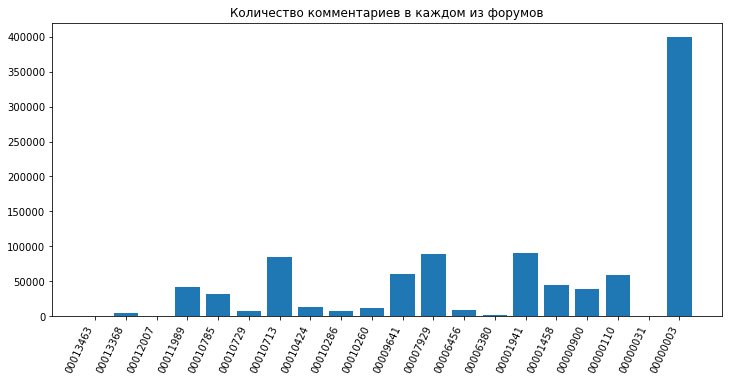

In [51]:
fig, ax = plt.subplots()
plt.title('Количество комментариев в каждом из форумов')

ax.bar(names.keys(), [y.count(code) for code in names])

fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure
fig.autofmt_xdate(rotation = 65)
plt.savefig('Комментарии.png', facecolor = 'white')

plt.show()